In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn import metrics

#load data
test_data = pd.read_csv("test.csv") #only has features
train_data = pd.read_csv("train.csv") #has label and features

#Split into labels and features
X = train_data.iloc[:, 1:]
y = train_data.iloc[:, 0].values.ravel()

#Split training into 80% train and 20% validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

#Train Decision Tree
dt = DecisionTreeClassifier(random_state=42)
dt = dt.fit(X_train, y_train)
dt_pred = dt.predict_proba(X_val)[:, 1]
print("Decision Tree parameters:")
print(dt.get_params())

#Train Boosted Tree
param_grid = {
    'n_estimators': [300, 400,500],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [5, 6, 8],
    'subsample': [0.8, 0.9, 1.0],           
    'min_samples_split': [2, 5, 10],              
    'min_samples_leaf': [1, 2, 4]                 
}

boosted_tree = GradientBoostingClassifier(random_state=42)
rand_search_cv = RandomizedSearchCV(estimator=boosted_tree, param_distributions=param_grid, cv=3, scoring='roc_auc', n_iter=10, random_state=42)
rand_search_cv.fit(X_train, y_train)

best_bt = rand_search_cv.best_estimator_
best_params = rand_search_cv.best_params_

best_bt_pred = best_bt.predict_proba(X_val)[:, 1]
print("Best Boosted Tree parameters:", best_params)


Decision Tree parameters:
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 42, 'splitter': 'best'}
Best Boosted Tree parameters: {'subsample': 0.8, 'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 6, 'learning_rate': 0.05}


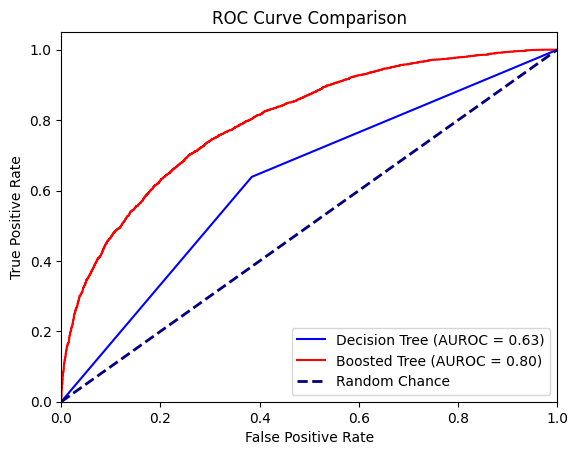


AUROC for Decision Tree:  0.6273560745789929

AUROC for Boosted Tree:  0.7977862461375136



In [94]:
# Compute ROC for Decision Tree
fpr_dt, tpr_dt, thresholds_dt = metrics.roc_curve(y_val, dt_pred, pos_label=1)
dt_auroc = metrics.auc(fpr_dt, tpr_dt)

# Compute ROC for Boosted Tree
fpr_bt, tpr_bt, thresholds_bt = metrics.roc_curve(y_val, best_bt_pred, pos_label=1)
best_bt_auroc = metrics.auc(fpr_bt, tpr_bt)

plt.plot(fpr_dt, tpr_dt, color='blue', label='Decision Tree (AUROC = %0.2f)' % dt_auroc)
plt.plot(fpr_bt, tpr_bt, color='red', label='Boosted Tree (AUROC = %0.2f)' % best_bt_auroc)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Chance')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

print()
print("AUROC for Decision Tree: ", dt_auroc)
print()
print("AUROC for Boosted Tree: ", best_bt_auroc)
print()

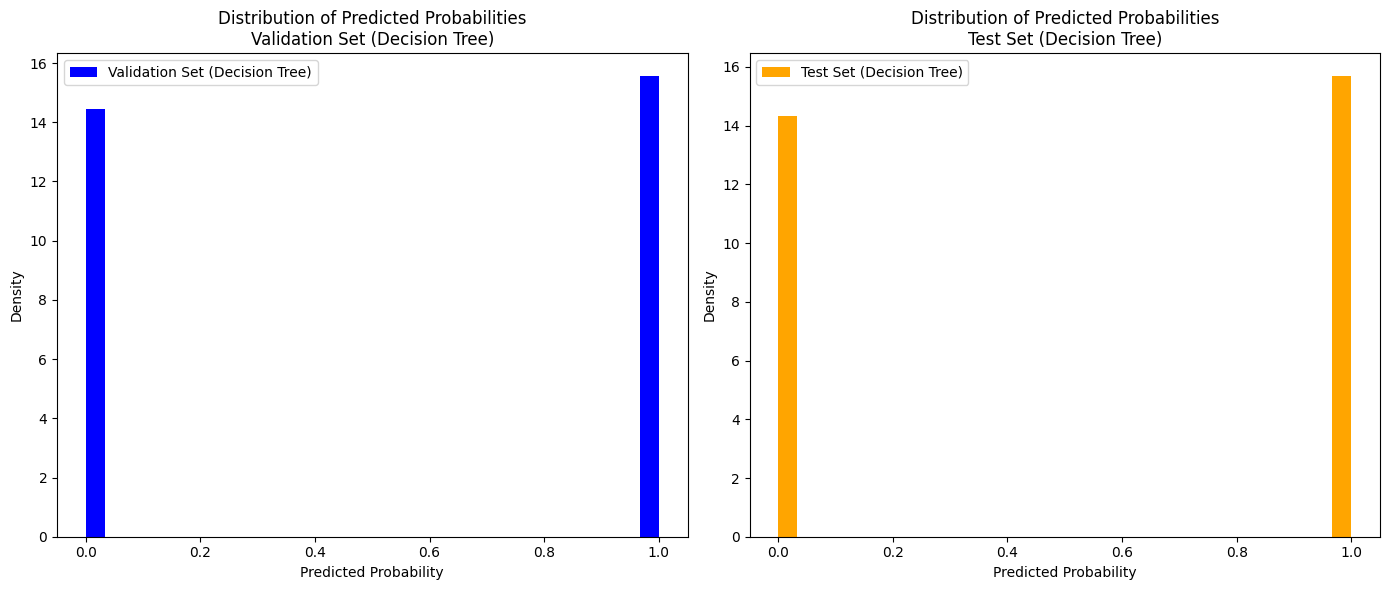

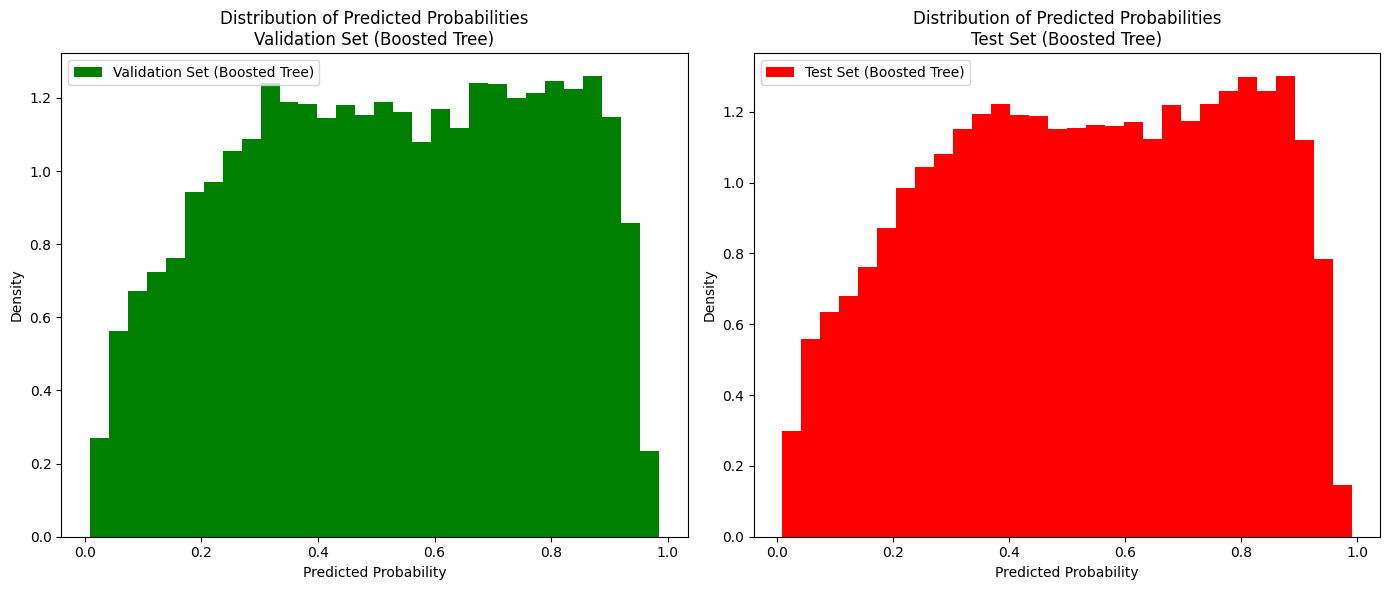

In [95]:
#Demonstrate performance on clean test set for Decision Tree and Boosted Tree
dt_test_pred =  dt.predict_proba(test_data)[:, 1]

bt_test_pred = best_bt.predict_proba(test_data)[:, 1]

# Create a figure with 1 row and 2 columns for Decision Tree predictions
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot Decision Tree validation set predictions
ax[0].hist(dt_pred, bins=30, label="Validation Set (Decision Tree)", color='blue', density=True)
ax[0].set_title("Distribution of Predicted Probabilities\nValidation Set (Decision Tree)")
ax[0].set_xlabel("Predicted Probability")
ax[0].set_ylabel("Density")
ax[0].legend()

# Plot Decision Tree test set predictions
ax[1].hist(dt_test_pred, bins=30, label="Test Set (Decision Tree)", color='orange', density=True)
ax[1].set_title("Distribution of Predicted Probabilities\nTest Set (Decision Tree)")
ax[1].set_xlabel("Predicted Probability")
ax[1].set_ylabel("Density")
ax[1].legend()

plt.tight_layout()
plt.show()

# Create a figure with 1 row and 2 columns for Boosted Tree predictions
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot Boosted Tree validation set predictions
ax[0].hist(best_bt_pred, bins=30, label="Validation Set (Boosted Tree)", color='green', density=True)
ax[0].set_title("Distribution of Predicted Probabilities\nValidation Set (Boosted Tree)")
ax[0].set_xlabel("Predicted Probability")
ax[0].set_ylabel("Density")
ax[0].legend()

# Plot Boosted Tree test set predictions
ax[1].hist(bt_test_pred, bins=30, label="Test Set (Boosted Tree)", color='red', density=True)
ax[1].set_title("Distribution of Predicted Probabilities\nTest Set (Boosted Tree)")
ax[1].set_xlabel("Predicted Probability")
ax[1].set_ylabel("Density")
ax[1].legend()

plt.tight_layout()
plt.show()


In [106]:
#getting predictions for test dataset
bt_predictions = best_bt.predict(test_data)

bt_predictions = bt_predictions.reshape(-1, 1)

num = bt_predictions.shape[0]

# Create Id column (0,1,2,...,N-1)
ids = np.arange(num).reshape(-1, 1)

# Stack Id and predictions into a single array
submission = np.hstack((ids, bt_predictions))  # Shape (N,2)

np.savetxt(
    fname="nsching_submission.csv",
    X=submission,
    header="Id,Predicted",
    delimiter=",",
    comments=""
)

print("Submission file 'nsching_submission.csv' saved successfully!")

Submission file 'nsching_submission.csv' saved successfully!


In [107]:
check_sub = pd.read_csv("nsching_submission.csv")

check_sub.head()

,Id,Predicted
0,0.0,0.0
1,1.0,0.0
2,2.0,1.0
3,3.0,1.0
4,4.0,1.0
